##**TalkingData: Click Fraud in Mobile advertisements**

Click fraud involves repeatedly clicking on ads to generate revenue for the host website or drain advertiser revenue. TalkingData serves advertisers and covers about 70% of China's mobile devices, with approximately 90% of clicks potentially being fraudulent.

##Goal and Importance


TalkingData wants to improve how they spot fake clicks, which can help advertisers save money. Right now, they keep a list of IP addresses that click a lot but don't lead to app installs. They want to get better at this by using smarter methods to predict if a click is real or fake.

**Key Points**

*   Click Fraud Overview:
        - Click fraud means repeatedly clicking on ads to make money or cause damage.
        - TalkingData helps advertisers, reaching 70% of mobile devices in China.
        - About 90% of clicks might be fake.

*   Objective and Significance:
        - Detecting click fraud reduces costs by recognizing valid clicks.
        - Current strategy: Blacklist IPs with high clicks but no app installs.
        - Aim: Use advanced techniques to predict genuine clicks.







##**Step 1- Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split      # For splitting data into train and test sets
from sklearn.model_selection import KFold                 # For performing K-fold cross-validation
from sklearn.model_selection import GridSearchCV          # For hyperparameter tuning using grid search
from sklearn.model_selection import cross_val_score       # For cross-validation score evaluation
from sklearn.preprocessing import LabelEncoder            # For label encoding categorical variables
from sklearn.tree import DecisionTreeClassifier           # For creating a Decision Tree classifier
from sklearn.ensemble import AdaBoostClassifier           # For creating an AdaBoost classifier
from sklearn.ensemble import GradientBoostingClassifier   # For creating a Gradient Boosting classifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import gc

%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')

##Step 2 - Importing Dataset

To avoid slowing down the program due to large data, it's crucial to save memory. This notebook shows some ways to do that.

In [2]:
dtypes = {
    'ip': 'uint16',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint16',
    'click_id': 'uint32'
}

colnames = ['ip','app','device','os','channel','click_time','is_attributed']

train_sample = pd.read_csv('/content/drive/MyDrive/DS/Step - Ensemble - Boosting/Notebook/Talking_data.csv', dtype=dtypes, usecols=colnames)

In [3]:
num_rows = len(train_sample)

print(f"Number of rows in the training dataset: {num_rows}")

Number of rows in the training dataset: 100000


In [4]:
memory_usage = train_sample.memory_usage()

print("Memory usage of each column:")
print(memory_usage)

Memory usage of each column:
Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    200000
dtype: int64


In [5]:
total_space_mb = train_sample.memory_usage().sum() / (1024**2)

print(f"Training dataset uses {total_space_mb:.2f} MB")

Training dataset uses 1.91 MB


In [6]:
print(train_sample.head())

      ip  app  device  os  channel           click_time  is_attributed
0  22004   12       1  13      497  2017-11-07 09:30:38              0
1  40024   25       1  17      259  2017-11-07 13:40:27              0
2  35888   12       1  19      212  2017-11-07 18:05:24              0
3  29048   13       1  13      477  2017-11-07 04:58:08              0
4   2877   12       1   1      178  2017-11-09 09:00:09              0


##**Step 2 - Exploring the Data - Univariate Analysis**

Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [7]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint16
dtypes: object(1), uint16(6)
memory usage: 1.9+ MB


#### Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded.

Let's try finding some useful trends in the data.

In [8]:

def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {column: fraction_unique(column) for column in train_sample.columns}

number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [9]:
print(train_sample.dtypes)


ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed    uint16
dtype: object


Let's now look at the distribution of the target variable 'is_attributed'.

In [10]:

percentage_distribution = (train_sample['is_attributed']
                           .value_counts(normalize=True, dropna=False)
                           .mul(100)
                           .round(2))


print(percentage_distribution)

0    99.77
1     0.23
Name: is_attributed, dtype: float64


  Only a very small portion, about 0.2%, of clicks are considered 'fraudulent'. This is common in fraud detection tasks. Dealing with this high class imbalance will likely be the toughest challenge in solving this problem.

###Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [11]:
app_target = train_sample.groupby('app')['is_attributed'].agg(mean='mean', count='count')


app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1



Let's start by removing apps that have a very low number of clicks, say less than 20%, and then visualize the remaining data.

In [12]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')

frequent_apps = frequent_apps[frequent_apps['count'] > frequent_apps['count'].quantile(0.80)]

frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')

frequent_apps.head()


,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


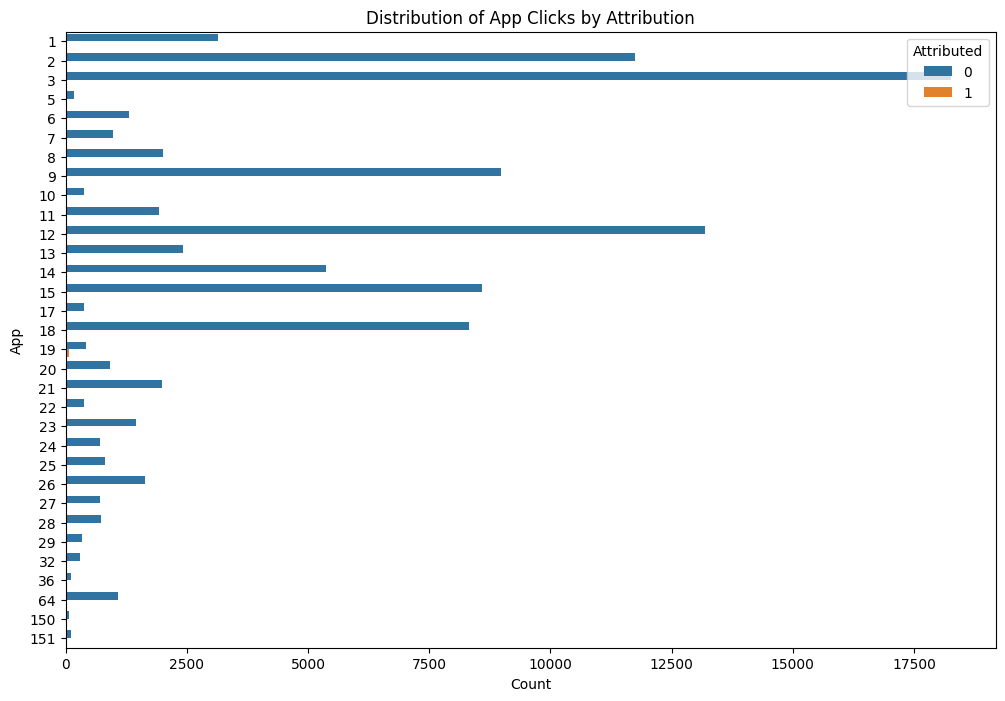

In [13]:
plt.figure(figsize=(12, 8))

sns.countplot(y="app", hue="is_attributed", data=frequent_apps)

plt.title("Distribution of App Clicks by Attribution")

plt.xlabel("Count")

plt.ylabel("App")

plt.legend(title="Attributed", loc="upper right")

plt.show()


Let's generate some new features from the existing data that might enhance the performance of the model.

##**Step 3: Feature Engineering**


Next, we'll create additional features based on the existing ones. We can extract features directly from the 'click_time' column and combine different attributes with the 'IP' field to form new features. This involves creating various combinations to enrich the dataset.

###Step 3.1- Datetime Based Features

In [14]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])

    df['day_of_week'] = df['datetime'].dt.dayofweek

    df['day_of_year'] = df['datetime'].dt.dayofyear

    df['month'] = df['datetime'].dt.month

    df['hour'] = df['datetime'].dt.hour

    return df


In [15]:
train_sample = timeFeatures(train_sample)

train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)

train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [16]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint16
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [17]:
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week', 'day_of_year', 'month', 'hour']

train_sample[int_vars] = train_sample[int_vars].astype('uint16')

memory_before_conversion_mb = train_sample.memory_usage().sum() / 1024**2

memory_after_conversion_mb = train_sample.memory_usage().sum() / 1024**2

print(f"Memory usage before dtype conversion: {memory_before_conversion_mb:.2f} MB")
print(f"Memory usage after dtype conversion: {memory_after_conversion_mb:.2f} MB")

Memory usage before dtype conversion: 1.91 MB
Memory usage after dtype conversion: 1.91 MB


We optimized our data by converting specific variables into the uint16 data type. This choice has two key benefits:

* Memory Efficiency: Using uint16 allows us to store values more efficiently in memory. By excluding negative numbers and adopting an unsigned representation, we conserve memory space.

* Extended Positive Range: While saving memory, uint16 also expands the positive value range. It can accommodate positive numbers twice as large as their signed counterparts, enhancing our ability to handle larger numeric values.

This strategic conversion of data types helps us balance efficient storage with the capacity to handle larger numerical values, contributing to memory optimization.

###Step 3.2- IP Grouping Based Features

####Feature Engineering: IP grouping and Click counts


To create important features, we'll group IP addresses with attributes such as operating system (os), channel, hour, and day. These features will include the count of unique IP addresses, which is a significant feature.

However, we need to be cautious with direct IP usage as a feature. New IP addresses in the test data could cause problems with categorization, disrupting predictions. Instead, we'll leverage click counts as features, emphasizing the importance of aggregating click counts based on IP address.

For memory efficiency, we'll specify the 'int16' data type during feature aggregation to optimize memory usage. This ensures efficient storage of numerical values while processing the data.

In [18]:
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count')

ip_count['ip_count'] = ip_count['ip_count'].astype('int16')

ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc.

The following function takes in a dataframe and creates these features.

In [19]:
def grouped_features(df):
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')

    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')

    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')

    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')

    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')

    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')

    df = pd.merge(df, ip_count, on='ip', how='left')
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')

    del ip_count, ip_day_hour, ip_hour_channel, ip_hour_os, ip_hour_app, ip_hour_device

    return df

In [20]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


##**Step 4- Splitting Dataset**


In [21]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=101)

##**Step 5- AdaBoost**

In [22]:
tree = DecisionTreeClassifier(max_depth=2)

adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,
                                      n_estimators=600,
                                      learning_rate=1.5,
                                      algorithm="SAMME")

adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.5, n_estimators=600)

In [23]:
predictions = adaboost_model_1.predict_proba(X_test)

print(predictions[:10])

[[0.53925405 0.46074595]
 [0.53984785 0.46015215]
 [0.5477702  0.4522298 ]
 [0.52640673 0.47359327]
 [0.52296322 0.47703678]
 [0.53217825 0.46782175]
 [0.52781137 0.47218863]
 [0.53560839 0.46439161]
 [0.52137713 0.47862287]
 [0.51815302 0.48184698]]


In [24]:
from sklearn import metrics

auc_score = metrics.roc_auc_score(y_test, predictions[:, 1])

print(auc_score)

0.94882318550071


###5.1 - AdaBoost - Hyperparameter Tuning


To optimize the hyperparameters of the AdaBoost classifier, we'll focus on two categories: those related to individual trees (like max_depth) and those tied to the ensemble (such as n_estimators, learning_rate, etc.).

To tune both sets of hyperparameters, we'll follow this approach: parameters with the format base_estimator_parameter_name refer to characteristics of the individual trees (base estimator), while all other parameters are related to the ensemble.

In [25]:
param_grid = {
    "base_estimator__max_depth": [2, 5],
    "n_estimators": [200,500]
}

In [26]:
tree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator=tree,
                         learning_rate=0.6,
                         algorithm="SAMME")

In [27]:
folds = 3

grid_search_ABC = GridSearchCV(ABC,
                               cv= folds,
                               param_grid=param_grid,
                               scoring= 'roc_auc',
                               return_train_score=True,
                               verbose=2)

In [28]:
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......base_estimator__max_depth=2, n_estimators=200; total time=  10.4s
[CV] END ......base_estimator__max_depth=2, n_estimators=200; total time=   9.9s
[CV] END ......base_estimator__max_depth=2, n_estimators=200; total time=   9.0s
[CV] END ......base_estimator__max_depth=2, n_estimators=500; total time=  25.7s
[CV] END ......base_estimator__max_depth=2, n_estimators=500; total time=  26.6s
[CV] END ......base_estimator__max_depth=2, n_estimators=500; total time=  26.0s
[CV] END ......base_estimator__max_depth=5, n_estimators=200; total time=  21.8s
[CV] END ......base_estimator__max_depth=5, n_estimators=200; total time=  22.8s
[CV] END ......base_estimator__max_depth=5, n_estimators=200; total time=  20.2s
[CV] END ......base_estimator__max_depth=5, n_estimators=500; total time=  54.0s
[CV] END ......base_estimator__max_depth=5, n_estimators=500; total time=  55.8s
[CV] END ......base_estimator__max_depth=5, n_est

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 500]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [29]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.465786,0.585575,0.304078,0.070585,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.930397,0.970941,0.942790,0.948043,0.016964,1,0.995996,0.994305,0.995299,0.99520,6.935398e-04
1,25.491183,0.378124,0.623859,0.004458,2,500,"{'base_estimator__max_depth': 2, 'n_estimators...",0.930398,0.965859,0.941021,0.945759,0.014860,2,0.997785,0.997007,0.997078,0.99729,3.512174e-04
2,21.261995,1.091443,0.316639,0.002761,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.922844,0.940970,0.936874,0.933563,0.007761,3,1.000000,1.000000,1.000000,1.00000,1.464296e-07
3,52.984609,1.419899,1.040138,0.209841,5,500,"{'base_estimator__max_depth': 5, 'n_estimators...",0.912107,0.932352,0.937254,0.927237,0.010885,4,1.000000,1.000000,1.000000,1.00000,0.000000e+00


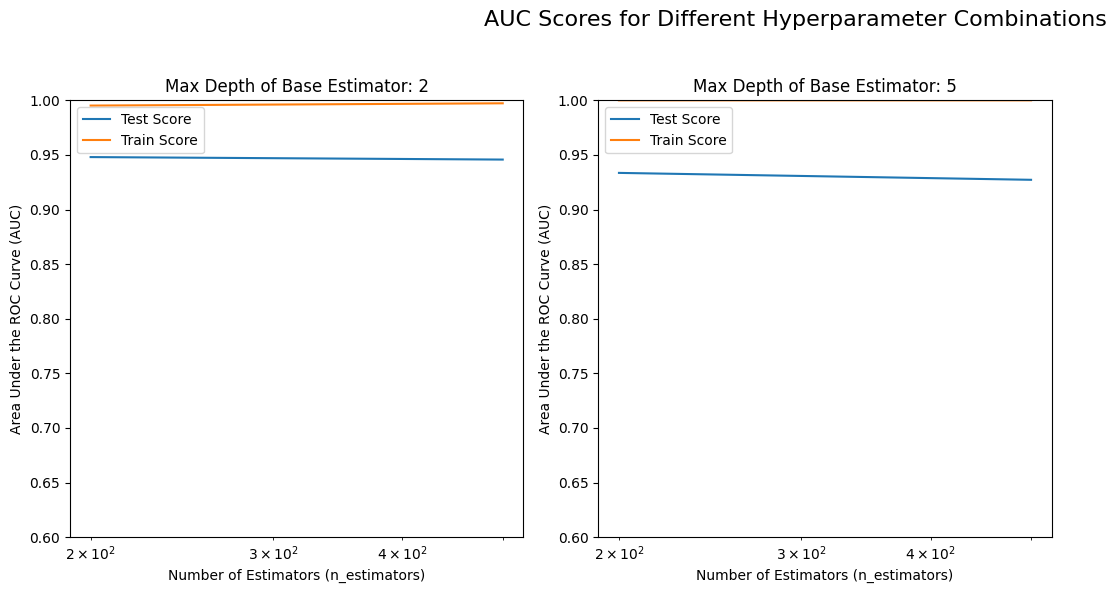

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

for n, depth in enumerate(param_grid['base_estimator__max_depth']):
  plt.subplot(1,3, n + 1)

  depth_df = cv_results[cv_results['param_base_estimator__max_depth']== depth]

  plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"], label='Test Score')
  plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"], label= 'Train Score')

  plt.xlabel('Number of Estimators (n_estimators)')
  plt.ylabel('Area Under the ROC Curve (AUC)')
  plt.title("Max Depth of Base Estimator: {0}".format(depth))
  plt.ylim([0.60, 1])
  plt.legend(loc='upper left')
  plt.xscale('log')

plt.suptitle("AUC Scores for Different Hyperparameter Combinations", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])

plt.show()

Here are the findings:

* Setting max_depth=5 results in overfitting, as indicated by a nearly perfect training AUC but lower performance on the test set.
* On the other hand, with max_depth=2, the model achieves around 95% AUC and demonstrates better generalization on the test set.

Based on these results, we select max_depth=2 and n_estimators=200 as our hyperparameters.

However, it's important to note that we haven't explored key hyperparameters like learning rate and subsample yet, which could significantly enhance results. Our next step involves experimenting with these hyperparameters to further improve the model's performance.

In [31]:
tree = DecisionTreeClassifier(max_depth=2)

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

test_predictions = ABC.predict_proba(X_test)

test_auc_score = metrics.roc_auc_score(y_test, test_predictions[:, 1])

print(test_auc_score)

0.9451398981040675


In [32]:
predictions = ABC.predict_proba(X_test)

print(predictions[:10])

[[0.59796045 0.40203955]
 [0.60845419 0.39154581]
 [0.64051425 0.35948575]
 [0.579381   0.420619  ]
 [0.58213755 0.41786245]
 [0.59757524 0.40242476]
 [0.58542268 0.41457732]
 [0.5952296  0.4047704 ]
 [0.59280746 0.40719254]
 [0.57972472 0.42027528]]


In [33]:
roc_auc = metrics.roc_auc_score(y_test, predictions[:,1])
print(roc_auc)

0.9451398981040675


##**Step 6- Gradient Boosting Classifier**


Let's delve into exploring the gradient boosting classifier. We'll focus on two crucial hyperparameters: learning_rate (shrinkage) and subsample.

Adjusting the learning_rate to be less than 1 introduces regularization to the model. Higher values allow for faster learning but may lead to overfitting, while lower values promote better generalization at the cost of slower learning.

Moreover, there's a trade-off between learning_rate and n_estimators. A higher learning rate often means fewer trees are needed, so typically only one of these two hyperparameters is tuned.

Additionally, subsampling (setting subsample to less than 1) enables constructing individual models on smaller, random subsets of the data. This reduces model variability by training each tree on different data portions, ultimately improving overall performance.




In [34]:
param_grid = {
    "learning_rate": [0.2, 0.6, 0.9],
    "subsample": [0.3,0.6,0.9]
}


In [35]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)


In [36]:
folds = 3

grid_search_GBC = GridSearchCV(GBC,
                               cv=folds,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               return_train_score=True,
                               verbose=1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2,
                                                  n_estimators=200),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [37]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)

print(cv_results.head())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.308451      0.613214         0.048517        0.006886   
1       7.844944      1.027845         0.041475        0.001531   
2       8.896456      0.513745         0.062418        0.018123   
3       4.882674      0.265082         0.052492        0.014651   
4       7.240701      0.442514         0.059347        0.012469   

  param_learning_rate param_subsample  \
0                 0.2             0.3   
1                 0.2             0.6   
2                 0.2             0.9   
3                 0.6             0.3   
4                 0.6             0.6   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.896065   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.791773   
2  {'learning_rate': 0.2, 'subsample': 0.9}           0.926583   
3  {'learning_rate': 0.6, 'subsample': 0.3}           0.662144   
4  {'learning_rate':

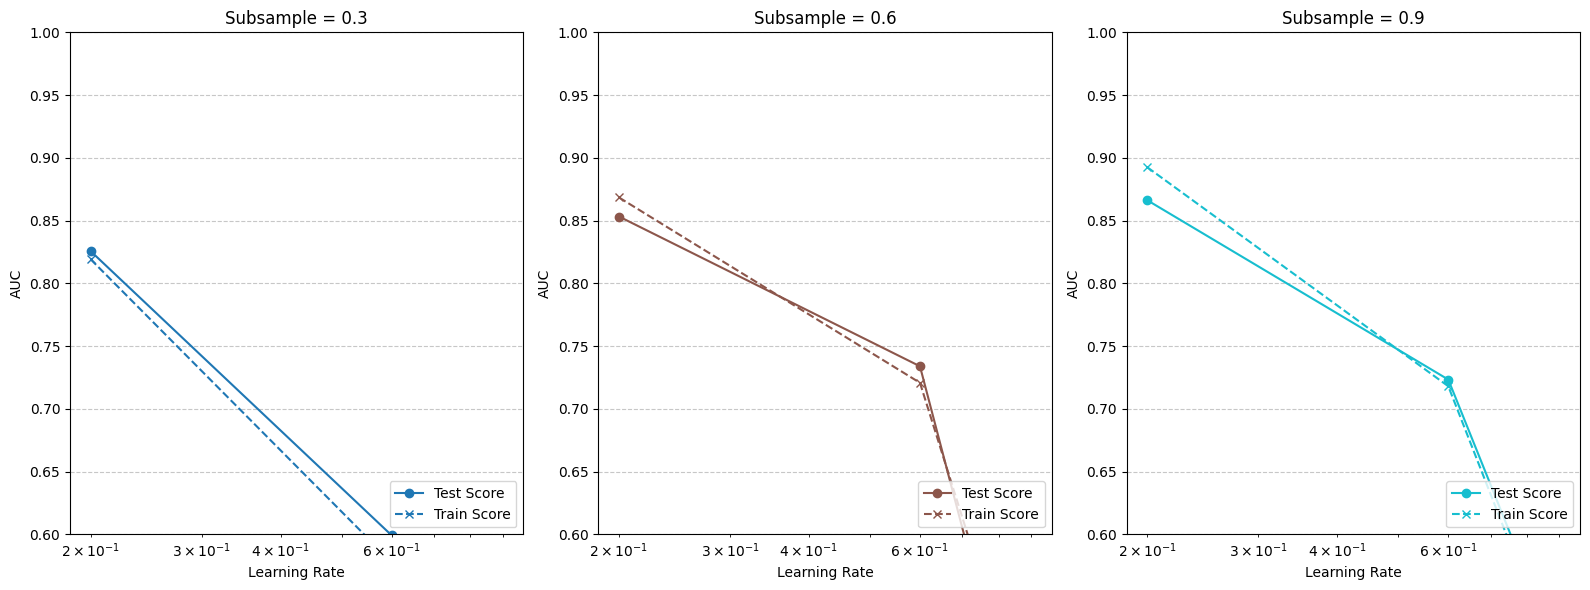

In [38]:
plt.figure(figsize=(16,6))

color_palette = plt.cm.get_cmap('tab10', len(param_grid['subsample']))

# Iterate over subsample values and create subplots
for n, subsample in enumerate(param_grid['subsample']):
    # Create a subplot within the figure
    plt.subplot(1, len(param_grid['subsample']), n + 1)

    # Filter results for the current subsample value
    df = cv_results[cv_results['param_subsample'] == subsample]

    # Plot mean_test_score with markers for test data
    plt.plot(df["param_learning_rate"], df["mean_test_score"], marker='o', color=color_palette(n))

    # Plot mean_train_score with markers and dashed lines for train data
    plt.plot(df["param_learning_rate"], df["mean_train_score"], marker='x', linestyle='--', color=color_palette(n))

    # Add labels and title
    plt.xlabel('Learning Rate')
    plt.ylabel('AUC')
    plt.title("Subsample = {0}".format(subsample))

    # Set y-axis limits
    plt.ylim([0.60, 1])

    # Add legend in the lower right corner
    plt.legend(['Test Score', 'Train Score'], loc='lower right')

    # Set x-axis to log scale
    plt.xscale('log')

    # Add dashed grid lines with slight transparency
    plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Display the final plot
plt.show()


The plot clearly illustrates that models with lower subsample ratios perform better, while those with higher subsamples tend to overfit.

Furthermore, lower learning rates result in less overfitting.

##**Step 7 - XGBoost**

Let's now explore XGBoost as our next step. The hyperparameters we'll focus on remain consistent, with key ones including subsample, learning_rate, and max_depth, among others.

In [39]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
y_pred = model.predict_proba(X_test)

print(y_pred[:10])

[[9.9999613e-01 3.8447001e-06]
 [9.9997354e-01 2.6451615e-05]
 [9.9999303e-01 6.9675366e-06]
 [9.9973100e-01 2.6898040e-04]
 [9.9992257e-01 7.7399302e-05]
 [9.9993002e-01 6.9950634e-05]
 [9.9992824e-01 7.1767608e-05]
 [9.9999464e-01 5.3787971e-06]
 [9.9985099e-01 1.4902154e-04]
 [9.9927807e-01 7.2194968e-04]]


In [41]:
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])

print("AUC: %.2f%%" % (roc * 100.0))

AUC: 95.29%



The ROC AUC with default hyperparameters is approximately 0.95%.

To improve this, let's try tuning the hyperparameters using k-fold cross-validation (CV). We'll then employ grid search CV to find the optimal values of hyperparameters. This approach will help us systematically explore different combinations of hyperparameters to identify the ones that yield the best performance for our model.

In [42]:
folds = 3

param_grid = {
    'learning_rate': [0.2,0.6],
   'subsample': [0.3, 0.6, 0.9]
}

# Specify the XGBoost model with initial hyperparameters
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# Set up GridSearchCV for hyperparameter tuning
model_cv = GridSearchCV(estimator=xgb_model,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

In [43]:
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [44]:
cv_results = pd.DataFrame(model_cv.cv_results_)

# Display the cross-validation results
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.386150,1.120520,0.054164,0.009334,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.909855,0.960380,0.964765,0.945000,0.024916,3,0.991639,0.976389,0.991267,0.986432,0.007103
1,0.555885,0.010476,0.047879,0.000559,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.912553,0.975454,0.950936,0.946314,0.025886,2,0.993283,0.988316,0.991739,0.991113,0.002075
2,0.511576,0.010780,0.048191,0.000615,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.915499,0.973977,0.953007,0.947494,0.024190,1,0.992662,0.989635,0.991708,0.991335,0.001264
3,0.569420,0.020419,0.052252,0.005908,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.902613,0.920755,0.963655,0.929008,0.025594,6,0.995808,0.990865,0.994425,0.993699,0.002082
4,0.564662,0.014188,0.052132,0.006247,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.904143,0.974484,0.953455,0.944028,0.029480,4,0.999069,0.997538,0.998502,0.998369,0.000632
5,1.335181,1.154660,0.049038,0.001012,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.906235,0.970282,0.952268,0.942928,0.026968,5,0.999193,0.998574,0.998942,0.998903,0.000254


In [45]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [46]:
# Convert 'param_learning_rate' column to float for plotting on the x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')

# Display the first few rows of the modified DataFrame
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.386150,1.120520,0.054164,0.009334,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.909855,0.960380,0.964765,0.945000,0.024916,3,0.991639,0.976389,0.991267,0.986432,0.007103
1,0.555885,0.010476,0.047879,0.000559,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.912553,0.975454,0.950936,0.946314,0.025886,2,0.993283,0.988316,0.991739,0.991113,0.002075
2,0.511576,0.010780,0.048191,0.000615,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.915499,0.973977,0.953007,0.947494,0.024190,1,0.992662,0.989635,0.991708,0.991335,0.001264
3,0.569420,0.020419,0.052252,0.005908,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.902613,0.920755,0.963655,0.929008,0.025594,6,0.995808,0.990865,0.994425,0.993699,0.002082
4,0.564662,0.014188,0.052132,0.006247,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.904143,0.974484,0.953455,0.944028,0.029480,4,0.999069,0.997538,0.998502,0.998369,0.000632


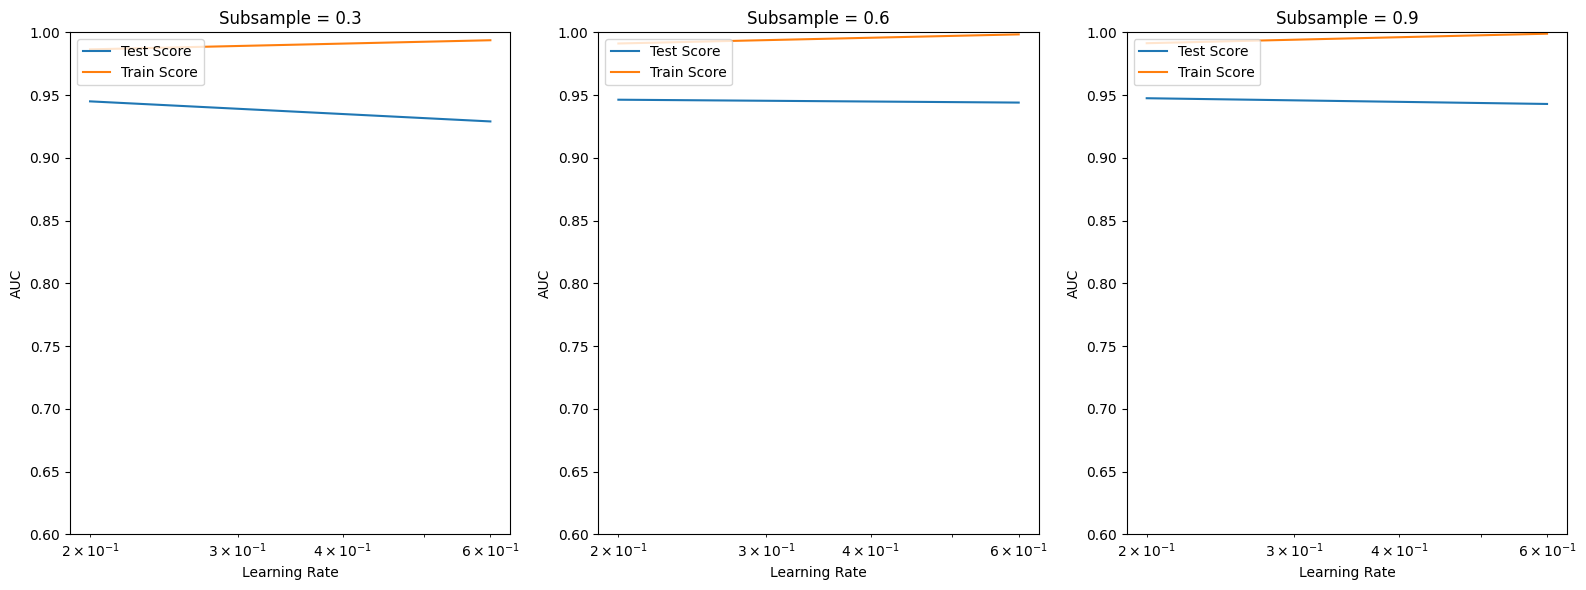

In [47]:
# Set the figure size for the plot
plt.figure(figsize=(16, 6))

# Define the parameter grid for plotting purposes
param_grid = {
    'learning_rate': [0.2, 0.6],
    'subsample': [0.3, 0.6, 0.9]
}

# Loop over each subsample value and create subplots
for n, subsample in enumerate(param_grid['subsample']):

    # Create a subplot for each subsample value
    plt.subplot(1, len(param_grid['subsample']), n + 1)

    # Filter the cross-validation results for the current subsample value
    df = cv_results[cv_results['param_subsample'] == subsample]

    # Plot mean_test_score and mean_train_score against learning_rate
    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])

    # Set labels and title
    plt.xlabel('Learning Rate')
    plt.ylabel('AUC')
    plt.title("Subsample = {0}".format(subsample))

    # Set y-axis limits
    plt.ylim([0.60, 1])

    # Add legend in the upper left corner
    plt.legend(['Test Score', 'Train Score'], loc='upper left')

    # Set x-axis to log scale
    plt.xscale('log')

# Display the plot
plt.tight_layout()
plt.show()



The results indicate that a subsample size of 0.6 and a learning rate of approximately 0.2 appear to be optimal. Additionally, XGBoost has yielded the highest ROC AUC among various hyperparameters tested.

With this information, let's proceed to build a final model using the chosen hyperparameters. We'll train the model on the entire dataset using these optimal hyperparameters to maximize performance.

In [48]:
params = {
    'learning_rate': 0.2,
    'max_depth': 2,
    'n_estimators': 200,
    'subsample': 0.6,
    'objective': 'binary:logistic'
}

# Initialize and fit the XGBoost model on the training data with the chosen hyperparameters
model = XGBClassifier(params=params)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6}, ...)

In [49]:
y_pred = model.predict_proba(X_test)

# Print the predicted probabilities for the first 10 samples
print("Predicted Probabilities for the first 10 samples:")
print(y_pred[:10])

Predicted Probabilities for the first 10 samples:
[[9.9999613e-01 3.8447001e-06]
 [9.9997354e-01 2.6451615e-05]
 [9.9999303e-01 6.9675366e-06]
 [9.9973100e-01 2.6898040e-04]
 [9.9992257e-01 7.7399302e-05]
 [9.9993002e-01 6.9950634e-05]
 [9.9992824e-01 7.1767608e-05]
 [9.9999464e-01 5.3787971e-06]
 [9.9985099e-01 1.4902154e-04]
 [9.9927807e-01 7.2194968e-04]]


The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [50]:
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])

# Print the calculated ROC AUC score
print("ROC AUC Score:", auc)

ROC AUC Score: 0.9529441242796292


Now, Lets also look at the feature importances

In [51]:
importance = dict(zip(X_train.columns, model.feature_importances_))

# Print the calculated feature importance dictionary
print("Feature Importance:")
print(importance)

Feature Importance:
{'ip': 0.054819837, 'app': 0.21427505, 'device': 0.32908294, 'os': 0.09152937, 'channel': 0.1885524, 'day_of_week': 0.06517318, 'day_of_year': 0.0, 'month': 0.0, 'hour': 0.056567177}


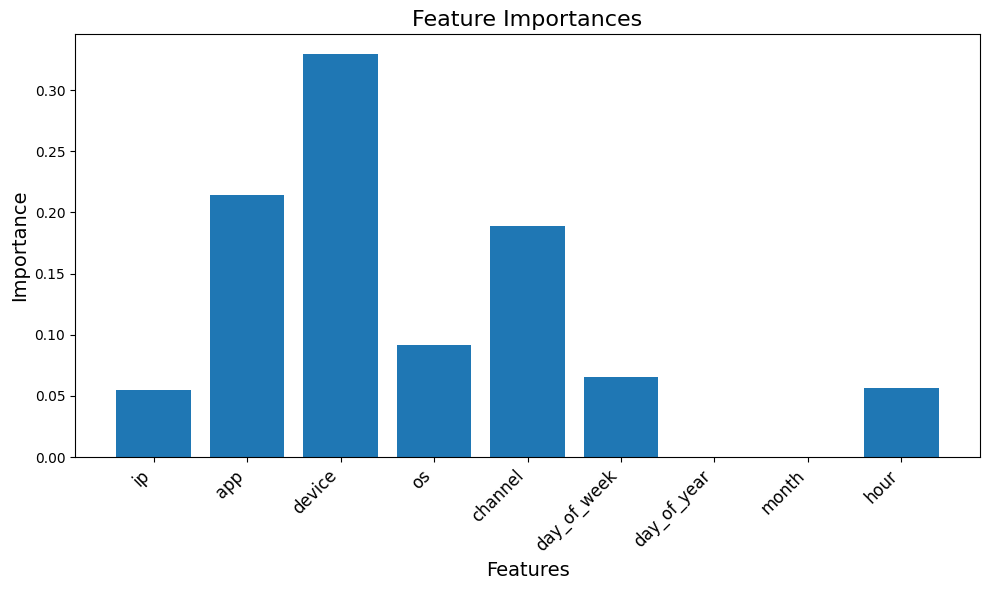

In [52]:
plt.figure(figsize=(10, 6))

# Create a bar plot with feature importances
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

# Customize the plot
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.xticks(range(len(model.feature_importances_)), importance, rotation=45, ha="right", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()